In [2]:
# first import 

import numpy as np
import os
import random
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import tensorflow as tf

Using TensorFlow backend.


In [22]:
# geting images
images = []
for imagename in os.listdir('../256_ObjectCategories/input/'):
    images.append(img_to_array(load_img('../256_ObjectCategories/input/'+imagename)))
images = np.array(images, dtype=float)

In [25]:
# setup test data
split = int(0.95*len(images))
imagesTrain = images[:split]
imagesTrain = 1.0/255*imagesTrain

In [26]:
#CNN model

from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Sequential

model = Sequential()

#Input Layer
model.add(Conv2D(64, (3, 3), input_shape=(256, 256, 1), activation='relu', padding='same'))

#Hidden Layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

#Compiling the CNN
model.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy'])

In [28]:
import matplotlib.pyplot as plt

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 20
def image_a_b_gen(batch_size):
    for batch in datagen.flow(imagesTrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# Train model      , callbacks=[tensorboard]
tensorboard = TensorBoard(log_dir="/output/beta_run")
trainedmodel = model.fit_generator(image_a_b_gen(batch_size),epochs=10, steps_per_epoch=10)


# summarize history for accuracy
plt.plot(trainedmodel.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(trainedmodel.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/10


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv2d_37/convolution (defined at C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_8797]

Function call stack:
keras_scratch_graph


In [12]:
# Save model

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [13]:
# load json and create model

from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [14]:
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 512)      

Output of the Model


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv2d_13_1/convolution (defined at C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_6342]

Function call stack:
keras_scratch_graph


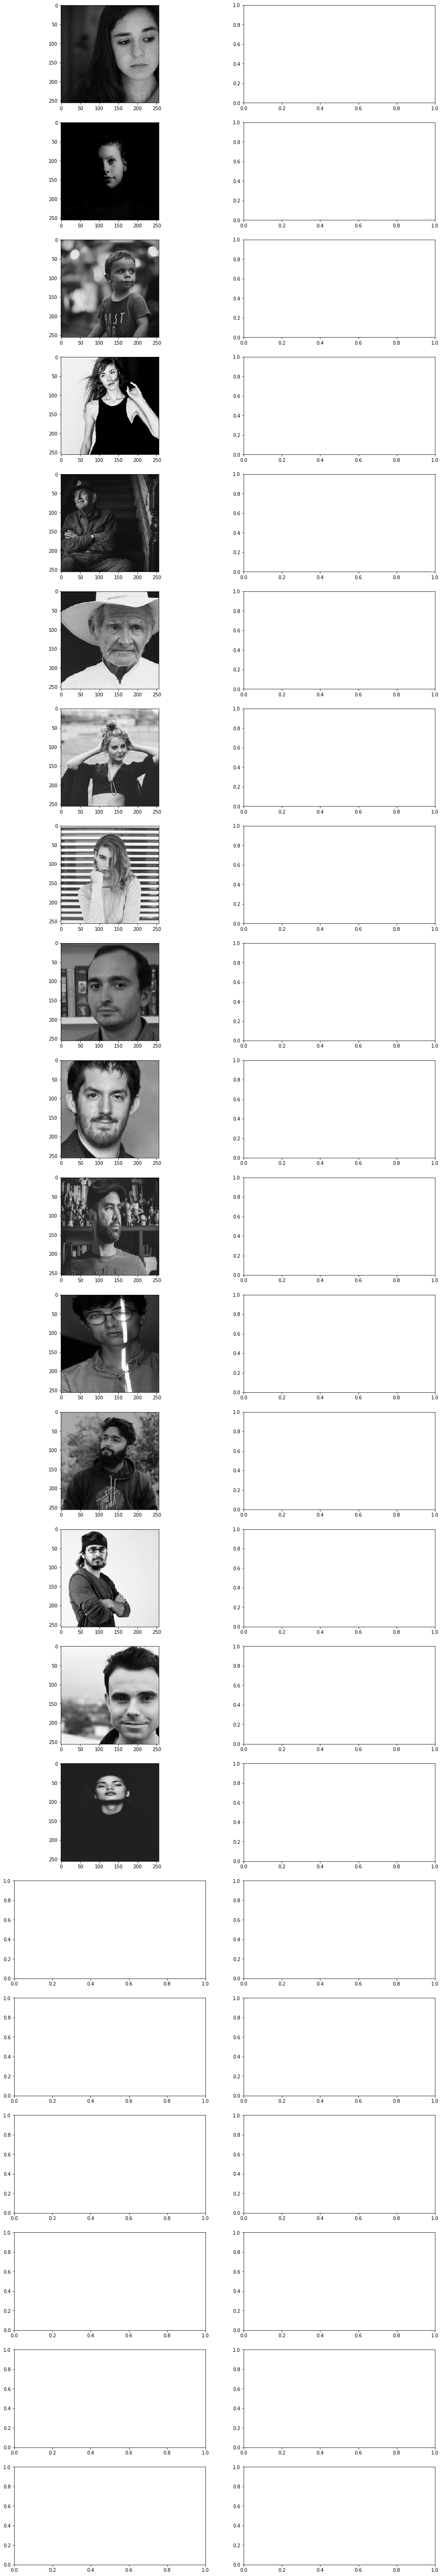

In [21]:
# Manual Testing of Images

#import cv2
import os
%matplotlib inline 
from matplotlib import pyplot as plt

fig, ax = plt.subplots(22, 2, figsize=(16,100))
row = 0
colorize = []
print('Output of the Model')
for filename in os.listdir('Images/Test/'):
	colorize.append(img_to_array(load_img('Images/Test/'+filename)))
	ax[row,0].imshow(load_img('Images/Test/'+filename), interpolation='nearest')
	row +=1

colorize = np.array(colorize, dtype=float)
colorize = rgb2lab(1.0/255*colorize)[:,:,:,0]
colorize = colorize.reshape(colorize.shape+(1,))


# Test model
output = loaded_model.predict(colorize)
output = output * 128

row = 0

# Output colorizations
for i in range(len(output)):
	cur = np.zeros((256, 256, 3))
	cur[:,:,0] = colorize[i][:,:,0]
	cur[:,:,1:] = output[i]
	resImage = lab2rgb(cur)
	ax[row,1].imshow(resImage, interpolation='nearest')
	row +=1
    
imsave("result/img_"+str(i)+".png", resImage)